# Exploring Pipelines and Wrapping Up Phase 3

## Why Pipeline?

Pipelines can keep our code neat and clean all the way from gathering & cleaning our data, to creating models & fine-tuning them!

**Advantages**: 
- Reduces complexity
- Convenient 
- Flexible 
- Can help prevent mistakes (like data leakage between train and test set) 

Easily integrate transformers and estimators, plus cross validation!

<img src="images/grid_search_cross_validation.png" alt="cross validation image from sklearn's documentation" width=500>

Why might CV be good in instances when we're doing things like searching for optimal hyperparameters...?

- 


In [25]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix

import category_encoders as ce

In [2]:
# May need to install category_encoders if you'd like to use it:
!pip install category_encoders

In [3]:
pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /opt/anaconda3/lib/python3.8/site-packages (2.2.2)
Note: you may need to restart the kernel to use updated packages.


In [4]:
def evaluate(estimator, X_train, X_test, y_train, y_test):
    '''
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    '''
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds)}")
    print(f"ROC-AUC: {roc_auc_score(y_train, train_preds)}")
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"F1 Score: {f1_score(y_test, test_preds)}")
    print(f"ROC-AUC: {roc_auc_score(y_test, test_preds)}")
    
    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test)
    plt.show()

Data source: https://www.kaggle.com/c/cat-in-the-dat-ii

In [5]:
# Grab, then explore data
df = pd.read_csv('data/cat_in_the_dat2_train.csv', index_col='id')

In [6]:
df.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600000 entries, 0 to 599999
Data columns (total 24 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bin_0   582106 non-null  float64
 1   bin_1   581997 non-null  float64
 2   bin_2   582070 non-null  float64
 3   bin_3   581986 non-null  object 
 4   bin_4   581953 non-null  object 
 5   nom_0   581748 non-null  object 
 6   nom_1   581844 non-null  object 
 7   nom_2   581965 non-null  object 
 8   nom_3   581879 non-null  object 
 9   nom_4   581965 non-null  object 
 10  nom_5   582222 non-null  object 
 11  nom_6   581869 non-null  object 
 12  nom_7   581997 non-null  object 
 13  nom_8   582245 non-null  object 
 14  nom_9   581927 non-null  object 
 15  ord_0   581712 non-null  float64
 16  ord_1   581959 non-null  object 
 17  ord_2   581925 non-null  object 
 18  ord_3   582084 non-null  object 
 19  ord_4   582070 non-null  object 
 20  ord_5   582287 non-null  object 
 21  day     58

In [8]:
# Exploring numeric cols - target is imbalanced
df.describe()

,bin_0,bin_1,bin_2,ord_0,day,month,target
count,582106.000000,581997.000000,582070.000000,581712.000000,582048.000000,582012.000000,600000.000000
mean,0.092301,0.185532,0.278704,1.948224,4.112767,6.371317,0.187205
std,0.289451,0.388729,0.448362,0.853904,2.034430,3.458959,0.390076
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,0.000000
50%,0.000000,0.000000,0.000000,2.000000,5.000000,6.000000,0.000000
75%,0.000000,0.000000,1.000000,3.000000,6.000000,8.000000,0.000000
max,1.000000,1.000000,1.000000,3.000000,7.000000,12.000000,1.000000


In [9]:
df['nom_0'].describe()

count     581748
unique         3
top          Red
freq      323286
Name: nom_0, dtype: object

In [10]:
# Exploring object cols 
df[[c for c in df.columns if df[c].dtype == 'object']].describe()

,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_1,ord_2,ord_3,ord_4,ord_5
count,581986,581953,581748,581844,581965,581879,581965,582222,581869,581997,582245,581927,581959,581925,582084,582070,582287
unique,2,2,3,6,6,6,4,1220,1519,222,222,2218,5,6,15,26,190
top,F,N,Red,Triangle,Hamster,India,Theremin,fc8fc7e56,ea8c5e181,4ae48e857,7d7c02c57,8f3276a6e,Novice,Freezing,n,N,Fl
freq,366212,312344,323286,164190,164897,164869,308621,977,805,5035,5052,565,160597,142726,70982,39978,10562


In [11]:
df['ord_2'].unique()
# This has pattern, can more usefully encode the data cold to warm 1-6

array(['Hot', 'Warm', 'Freezing', 'Lava Hot', 'Cold', 'Boiling Hot', nan],
      dtype=object)

In [12]:
# Exploring target distribution, imabalanced
df['target'].value_counts(normalize=True)

0    0.812795
1    0.187205
Name: target, dtype: float64

In [13]:
# Define our X and y
X = df.drop(columns='target', axis=1)
y = df['target']

# and train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Baseline Model

Let's find out how hard our problem is, by throwing things at it and seeing what sticks!

Biggest thing to think about - what types of columns need to be treated differently?

Reference: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [14]:
# Set up how to treat our columns

# Want to grab numeric columns
num_cols = []

# Then grab columns with fewer than 10 unique values
ohe_cols = []

# Then grab columns with more than 10, since we won't OHE those
freq_cols = []

for c in X.columns:
    if df[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif len(df[c].unique()) <= 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [15]:
# Check our work
print(f'Numeric: {num_cols}')
print(f'To OHE: {ohe_cols}')
print(f'To Freq: {freq_cols}')

Numeric: ['bin_0', 'bin_1', 'bin_2', 'ord_0', 'day', 'month']
To OHE: ['bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'ord_1', 'ord_2']
To Freq: ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_3', 'ord_4', 'ord_5']


In [16]:
# Now, set up the preprocessing steps for each type of col
# copied from https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')), # fill nulls with median
    ('scaler', MinMaxScaler())]) # scale

ohe_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))]) # OHE, ignore nulls

freq_transformer = Pipeline(steps=[
    ('freq_enc', ce.CountEncoder(normalize=True,
                                min_group_size=0.01,
                                min_group_name='Other'))]) # Count Encoder https://contrib.scikit-learn.org/category_encoders/count.html

In [26]:
num_transformer2 = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')), # fill nulls with median
    ('scaler', StandardScaler())]) # scale

In [17]:
# Put together our preprocessor using a Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols), #apply this set of steps, to these columns
        ('cat_ohe', ohe_transformer, ohe_cols),
        ('cat_freq', freq_transformer, freq_cols)])

In [18]:
# Just out of curiosity, let's see what this looks like 
preprocessor.fit_transform(X_train).shape

(480000, 63)

In [27]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.

clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(class_weight='balanced'))])

clf_logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bin_0', 'bin_1', 'bin_2',
                                                   'ord_0', 'day', 'month']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                       

Train Scores
------------
Accuracy: 0.6317458333333333
F1 Score: 0.391935217546853
ROC-AUC: 0.632042310668959
Test Scores
-----------
Accuracy: 0.6316916666666667
F1 Score: 0.39014226380207256
ROC-AUC: 0.6330130977897584


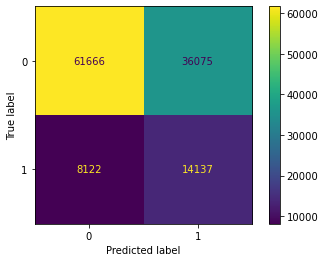

In [20]:
# Evaluate
evaluate(clf_logreg, X_train, X_test, y_train, y_test)
# Worse than dumb base line of guessing the majority class aka 80 something %
# Learned that the problem is difficult, data isn't linear

### Try Another Model Type

In [28]:
# Time for a new pipeline!
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

clf_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bin_0', 'bin_1', 'bin_2',
                                                   'ord_0', 'day', 'month']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                       

Train Scores
------------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Test Scores
-----------
Accuracy: 0.7122833333333334
F1 Score: 0.2691672664154777
ROC-AUC: 0.5475413206234585


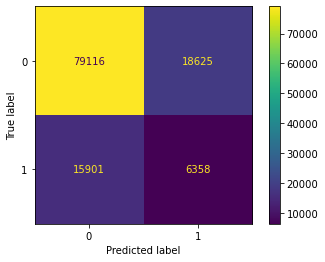

In [24]:
# Evaluate
evaluate(clf_dt, X_train, X_test, y_train, y_test)
# Better accuracy, worse ROC and F1 score

In [33]:
# Change Scaler to Standard -- update num transformer and preprocessor; back to Log Reg
num_transformer2 = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')), # fill nulls with median
    ('scaler', StandardScaler())]) # scale

preprocessor2 = ColumnTransformer(
    transformers=[
        ('num2', num_transformer2, num_cols), #apply this set of steps, to these columns
        ('cat_ohe', ohe_transformer, ohe_cols),
        ('cat_freq', freq_transformer, freq_cols)])

clf_lr2 = Pipeline(steps=[('preprocessor2', preprocessor),
                      ('classifier', LogisticRegression(class_weight='balanced'))])

clf_lr2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor2',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bin_0', 'bin_1', 'bin_2',
                                                   'ord_0', 'day', 'month']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                      

Train Scores
------------
Accuracy: 0.63165
F1 Score: 0.3919192197108308
ROC-AUC: 0.632030289437005
Test Scores
-----------
Accuracy: 0.631625
F1 Score: 0.3901496861419604
ROC-AUC: 0.6330242150962055


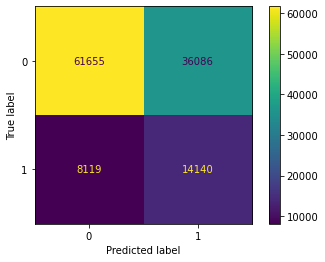

In [34]:
evaluate(clf_lr2, X_train, X_test, y_train, y_test)

In [35]:
cross_val_score(clf_dt, X_train, y_train, cv=5)
# will give you an array, will give you sense of score and standard deviation

NameError: name 'cross_val_score' is not defined

## Discussion Time!

What does it mean to decide between model types? What do we think best represents this data? What else might I want to explore or understand before deciding that?

- 


## Resources

Check out Aurélien Geron's notebook of an [end-to-end ml project](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) on his GitHub repo based around his book [_Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd ed)_](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/)